## Inventory Forecasting Analysis

In [1]:
#Grab historical Sales data
#Seasonality Variables, Qtr, Period
#Event sku?
# Sku age
# CPI
#%matplotlib inline

In [2]:
print(str(60000*60*365))

1314000000


In [3]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")

import HelperPI
import seaborn as sbs
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts

In [4]:
helper = HelperPI.Helper()

INFO:root:Initializing...


### Grabbing the data via pyodbc

In [58]:
sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\InventoryForecasting.sql")

In [59]:
base, dtypesdf = helper.readData(sql)

INFO:root:Reading data...
INFO:root:Data read complete...
INFO:root:Read: 1078 rows.


                 Count Column Type
0           DATE_VALUE      object
1     CALENDAR_QUARTER       int64
2       CALENDAR_MONTH       int64
3            DAYINWEEK       int64
4          HOL14DAYPRE       int64
5              UMCSENT     float64
6         STORE_NUMBER      object
7   SKU_DISPLAY_NUMBER      object
8              SKU_AGE       int64
9            EVENT_SKU       int64
10        TARGET_UNITS     float64


In [68]:
base.describe()

,CALENDAR_QUARTER,CALENDAR_MONTH,DAYINWEEK,HOL14DAYPRE,UMCSENT,SKU_AGE,EVENT_SKU,TARGET_UNITS
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.0,1078.000000,1078.000000
mean,2.406308,6.202226,4.072356,0.204082,90.517254,6038.0,0.012987,13.731911
std,1.171480,3.638737,2.010270,0.403216,5.318645,0.0,0.113271,22.987371
min,1.000000,1.000000,1.000000,0.000000,80.000000,6038.0,0.000000,1.000000
25%,1.000000,3.000000,2.000000,0.000000,87.200000,6038.0,0.000000,3.000000
50%,2.000000,6.000000,4.000000,0.000000,91.300000,6038.0,0.000000,6.000000
75%,4.000000,10.000000,6.000000,0.000000,94.700000,6038.0,0.000000,15.000000
max,4.000000,12.000000,7.000000,1.000000,98.500000,6038.0,1.000000,254.000000


In [69]:
base.head()

,DATE_VALUE,CALENDAR_QUARTER,CALENDAR_MONTH,DAYINWEEK,HOL14DAYPRE,UMCSENT,STORE_NUMBER,SKU_DISPLAY_NUMBER,SKU_AGE,EVENT_SKU,TARGET_UNITS
0,2014-01-01,1,1,4,1,81.2,001,876269,6038,0,12.0
1,2014-01-02,1,1,5,0,81.2,001,876269,6038,0,10.0
2,2014-01-03,1,1,6,0,81.2,001,876269,6038,0,11.0
3,2014-01-04,1,1,7,0,81.2,001,876269,6038,0,42.0
4,2014-01-05,1,1,1,0,81.2,001,876269,6038,0,13.0


### Preliminary OLS results

In [70]:
formula = 'TARGET_UNITS ~ C(CALENDAR_MONTH) + C(EVENT_SKU) + C(DAYINWEEK) + C(HOL14DAYPRE) + UMCSENT'
model = sts.ols(formula, data=base).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TARGET_UNITS   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     143.7
Date:                Mon, 21 Aug 2017   Prob (F-statistic):          2.14e-284
Time:                        16:31:26   Log-Likelihood:                -4200.7
No. Observations:                1078   AIC:                             8443.
Df Residuals:                    1057   BIC:                             8548.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  42.3754      7.058      6.004      0.000      28.527      56.224
C(CALENDAR_MONTH)[T.2]     -4.7691      1.610     -2.962      0.003      -7.929      -1.609
C(CALENDAR_MONTH)[T.3]     -8.6954      1.588     -5.475      0.000     -11.812      -5.579
C(CALENDAR_MONTH)[T.4]     -9.5419      1.654     -5.769      0.000     -12.787      -6.297
C(CALENDAR_MONTH)[T.5]    -11.9295      1.781     -6.697      0.000     -15.425      -8.434
C(CALENDAR_MONTH)[T.6]    -10.5381      1.919     -5.493      0.000     -14.303      -6.773
C(CALENDAR_MONTH)[T.7]    -11.8655      1.955     -6.069      0.000     -15.702      -8.029
C(CALENDAR_MONTH)[T.8]     -6.8215      1.776     -3.842      0.000     -10.306      -3.337
C(CALENDAR_MONTH)[T.9]     -5.4704      1.724     -3.172      0.002      -8.854      -2.087
C(CALENDAR_MONTH)[T.10]     0.2657      1.765      0.151      0.880      -3.198       3.730
C(CALENDAR_MONTH)[T.11]    12.5252      1.752      7.147      0.000       9.086      15.964
C(CALENDAR_MONTH)[T.12]    27.0254      1.826     14.802      0.000      23.443      30.608
C(EVENT_SKU)[T.1]         138.6530      3.491     39.719      0.000     131.803     145.503
C(DAYINWEEK)[T.2]          -2.1800      1.399     -1.558      0.119      -4.925       0.565
C(DAYINWEEK)[T.3]          -3.1194      1.396     -2.235      0.026      -5.858      -0.381
C(DAYINWEEK)[T.4]          -3.4201      1.397     -2.447      0.015      -6.162      -0.678
C(DAYINWEEK)[T.5]          -2.8067      1.393     -2.015      0.044      -5.540      -0.073
C(DAYINWEEK)[T.6]           1.3256      1.382      0.959      0.338      -1.386       4.037
C(DAYINWEEK)[T.7]           4.9267      1.365      3.609      0.000       2.248       7.605
C(HOL14DAYPRE)[T.1]         3.1149      1.107      2.813      0.005       0.942       5.288
UMCSENT                    -0.3136      0.075     -4.184      0.000      -0.461      -0.167
==============================================================================
Omnibus:                      558.596   Durbin-Watson:                   1.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15568.275
Skew:                           1.811   Prob(JB):                         0.00
Kurtosis:                      21.261   Cond. No.                     1.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Data Description

In [74]:
a = model.get_influence()
a.summary_table()

obs,endog,fitted,Cook's,student.,hat diag,dffits,ext.stud.,dffits
,,value,d,residual,,internal,residual,
0.0,12.0,16.6030147376,0.000197071422345,-0.387753711351,0.0267878909984,-0.0643311733863,-0.387597814037,-0.064305308883
1.0,10.0,14.1014698714,0.000106993246933,-0.344064373861,0.0186264713773,-0.0474010357017,-0.343920839708,-0.0473812612989
2.0,11.0,18.2337581189,0.000328305930693,-0.606750754787,0.0183831269864,-0.0830326715489,-0.606569312721,-0.0830078415519
3.0,42.0,21.8348673378,0.00253022843098,1.69127847527,0.0182370843221,0.230509863239,1.69277026354,0.230713183931
4.0,13.0,16.9081743371,9.7471117218e-05,-0.327859214604,0.0186865109217,-0.0452426067063,-0.327720752612,-0.0452234997812
5.0,19.0,14.7281367334,0.000117718225846,0.358404918785,0.0188815022244,0.0497200436721,0.358257109542,0.0496995387023
6.0,30.0,13.7887475657,0.00169670714392,1.3601179346,0.0188967775544,0.188761357333,1.36066561016,0.188837365435
7.0,14.0,13.4881087368,1.66418256246e-06,0.0429409971489,0.0186003833729,0.00591166929147,0.0429207171037,0.00590887734605
8.0,12.0,14.1014698714,2.8088183381e-05,-0.176288242549,0.0186264713773,-0.0242868658126,-0.176207422387,-0.0242757313863


### Point Biserial Correlation
For Target_Units vs the Event Sku flag.

In [67]:
corr, pval = stats.pointbiserialr(base['HOL14DAYPRE'], base['TARGET_UNITS'])
print('Point Biserial Correlation \n Coeff: ' + str(corr) + '\n pval: ' + str(pval))

Point Biserial Correlation 
 Coeff: 0.163282409297
 pval: 7.00526182551e-08


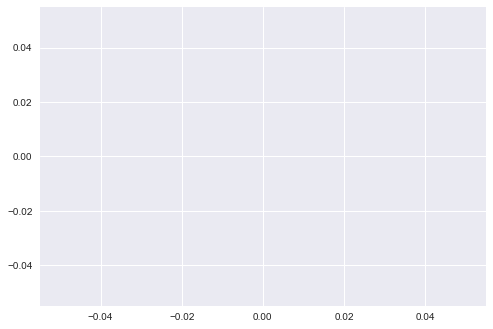

In [66]:
plt.plot(x=base['HOL14DAYPRE'], y=base['TARGET_UNITS'])
plt.show()